# 2nd PCEO AI CLUB competition - Official Baseline
## 2회 PCEO AI CLUB 대회 - 공식 베이스라인
안녕하세요! 이번 대회 Host 김동규입니다. 이번 대회는 저번 첫번째 대회의 연장선상으로 classical ML 데이터를 이용한 대회입니다. 저번 대회보다 훨씬 많고 다양해진 feature들을 어떻게 효과적으로 훈련시켜 최적의 모델을 찾을 수 있을까요? 큰 데이터와 NaN 값을 처리하는 방식이 이 대회의 점수를 크게 가를 것입니다. 

아래는 간단한 베이스라인입니다. 대회에 submission 할 수 있는 최소한의 코드로 구성되어 있습니다. 아래 코드를 기반으로 하여 점수를 향상하고 리더보드의 상단에 위치하여 보세요!

리더보드 1등에게 소정의 상품이 주어집니다

### 데이터 및 라이브러리 로드

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
import folium

In [2]:
train = pd.read_csv('../input/pceo-ai-club2/train.csv', index_col='ID')
test = pd.read_csv('../input/pceo-ai-club2/test.csv', index_col='ID')
sample_submission = pd.read_csv('../input/pceo-ai-club2/sample_submission.csv', index_col='ID')

### EDA

In [3]:
train.columns

Index(['Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat',
       'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street', 'Side',
       'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Severity'],
      dtype='object')

In [4]:
train.Severity.unique()

array([2, 3, 4, 1])

<AxesSubplot:ylabel='Severity'>

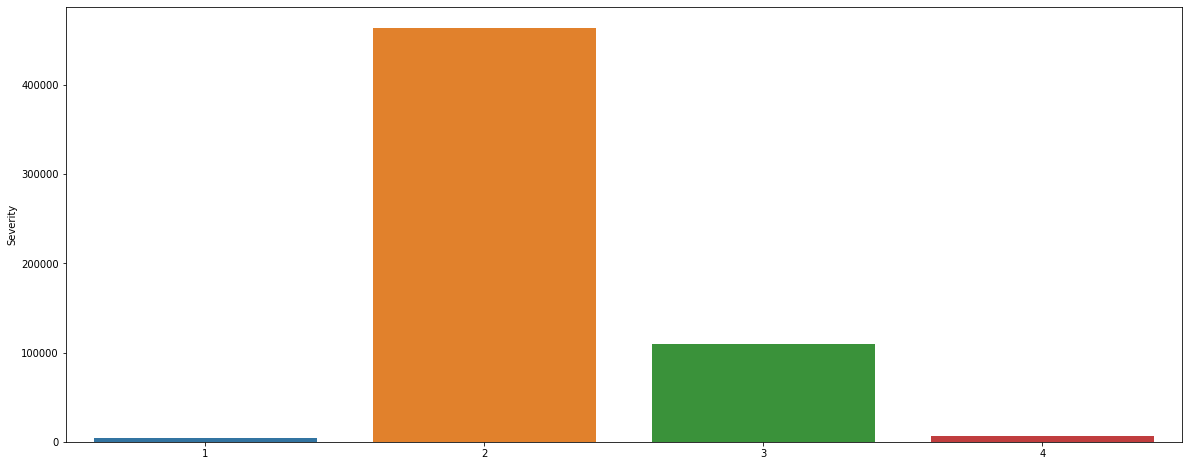

In [5]:
plt.figure(figsize=(20,8))
sns.barplot(x = [2,3,4,1], y=train.Severity.value_counts())

Severity가 우리가 예측해야 하는 교통사고의 세기입니다. 다음과 같이 1,2,3,4의 4가지 세기로 구분되어 있습니다. 또한, 다음처럼 균형이 망가진 모습을 보이고 있습니다

In [6]:
train.isnull().any()

Start_Time               False
End_Time                 False
Start_Lat                False
Start_Lng                False
End_Lat                   True
End_Lng                   True
Distance(mi)             False
Description              False
Number                    True
Street                   False
Side                     False
City                      True
County                   False
State                    False
Zipcode                   True
Country                  False
Timezone                  True
Airport_Code              True
Weather_Timestamp         True
Temperature(F)            True
Wind_Chill(F)             True
Humidity(%)               True
Pressure(in)              True
Visibility(mi)            True
Wind_Direction            True
Wind_Speed(mph)           True
Precipitation(in)         True
Weather_Condition         True
Amenity                  False
Bump                     False
Crossing                 False
Give_Way                 False
Junction

위와 같이 어떤 feature는 NaN 값이 없고, 어떤 feature는 NaN 값이 있습니다. 

In [7]:
LA_lat = train.loc[train.City=="Los Angeles"]['Start_Lat']
LA_lng = train.loc[train.City=="Los Angeles"]['Start_Lng']
LA_des = train.loc[train.City=="Los Angeles"]['Description']
LA = pd.concat([LA_lat, LA_lng,LA_des], axis=1)

In [8]:
m = folium.Map(location=[LA.Start_Lat.mean(),LA.Start_Lng.mean()], tiles='openstreetmap', zoom_start = 11)
for i in range (1000):
    try:
        folium.Marker(location=[LA['Start_Lat'][i], LA['Start_Lng'][i]],
                     popup=LA['Description'][i],
                     icon = folium.Icon(prefix = 'fa', icon = "map-pin", color = 'blue'),
                     fill_color='#132b5e', num_sides=3, radius=5).add_to(m)
    except:
        continue
m

LA에서 일어난 교통사고 55000여 건 중 1000건을 무작위로 지도 위에 표시한 모습입니다. 위와 같은 방식으로 어디에서 사고가 일어났는지 정확하게 알 수 있습니다. 

### Data Preprocessing

In [9]:
y = train.Severity
X = train.drop(['Severity'], axis=1)

간단한 베이스라인이기 때문에 SimpleImputer 등을 이용하지 않고, Nan 값이 있는 column들은 모두 삭제하겠습니다.

In [10]:
s = (train.isnull().any())
nan_cols = list(s[s].index)
X = X.drop(nan_cols, axis=1)
test = test.drop(nan_cols, axis=1)

Description과 Street는 종류가 너무 많기 때문에 삭제합니다. County에서 test에만 있고 train에는 없는 category value가 있으므로 삭제해줍니다.

In [11]:
len(X.Description.unique())

262210

In [12]:
len(X.Street.unique())

28390

In [13]:
X = X.drop(['Description', 'Street', 'County'], axis=1)
test = test.drop(['Description', 'Street','County'], axis=1)

In [14]:
obj = (X.dtypes == 'object')
object_cols = list(obj[obj].index)
object_cols

['Side', 'State', 'Country']

In [15]:
X.Side.iloc[0] = ' ' #test에 이와 같이 NaN값이 처리되어 있어 OrdinalEncoding을 위하여 이렇게 바꾸어 주었다.

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [16]:
label_X = X.copy()
label_test = test.copy()

ordinal_encoder = OrdinalEncoder()
label_X[object_cols] = ordinal_encoder.fit_transform(X[object_cols])
label_test[object_cols] = ordinal_encoder.transform(test[object_cols])

In [17]:
X_train, X_val, y_train, y_val = train_test_split(label_X, y, test_size=0.2, random_state=3)

In [18]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
pred = model.predict(X_val)
accuracy_score(pred, y_val)

0.8991010870773783

### Model predict & submission

In [20]:
result = model.predict(label_test)
submission = pd.DataFrame(result,columns=["Severity"], index=label_test.index)
submission.to_csv("submission.csv")